## 1- Import Libraries

In [33]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import re, nltk, string, os
from nltk.corpus import stopwords
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hassa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2- Load & Explore the Data
-  I noticed in Dataset Card that column names aren't correct so I loaded directly with the correct names

In [5]:
col_names = ['id', 'entity', 'sentiment', 'tweet']
df_train = pd.read_csv('twitter_training.csv',
                       names=col_names)
df_test = pd.read_csv('twitter_validation.csv',
                     names=col_names)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74682 non-null  int64 
 1   entity     74682 non-null  object
 2   sentiment  74682 non-null  object
 3   tweet      73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


- there are some null values in tweet column 

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1000 non-null   int64 
 1   entity     1000 non-null   object
 2   sentiment  1000 non-null   object
 3   tweet      1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


-  test is clean of nulls ;)

In [8]:
df_train.head()

,id,entity,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [9]:
df_test.head()

,id,entity,sentiment,tweet
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [10]:
df_train['entity'].value_counts()

entity
TomClancysRainbowSix                 2400
MaddenNFL                            2400
Microsoft                            2400
LeagueOfLegends                      2394
CallOfDuty                           2394
Verizon                              2382
CallOfDutyBlackopsColdWar            2376
ApexLegends                          2376
Facebook                             2370
WorldOfCraft                         2364
Dota2                                2364
NBA2K                                2352
TomClancysGhostRecon                 2346
Battlefield                          2346
FIFA                                 2340
Xbox(Xseries)                        2334
Overwatch                            2334
johnson&johnson                      2328
Amazon                               2316
PlayStation5(PS5)                    2310
HomeDepot                            2310
Cyberpunk2077                        2304
CS-GO                                2304
GrandTheftAuto(GTA)        

In [11]:
df_test['entity'].value_counts()

entity
RedDeadRedemption(RDR)               40
johnson&johnson                      39
FIFA                                 38
PlayerUnknownsBattlegrounds(PUBG)    38
LeagueOfLegends                      37
ApexLegends                          36
TomClancysRainbowSix                 35
Nvidia                               35
GrandTheftAuto(GTA)                  35
Amazon                               34
Fortnite                             34
Facebook                             33
PlayStation5(PS5)                    33
AssassinsCreed                       33
Borderlands                          33
Overwatch                            32
Hearthstone                          32
Verizon                              32
CS-GO                                32
CallOfDuty                           31
Cyberpunk2077                        30
WorldOfCraft                         30
MaddenNFL                            29
Microsoft                            28
Dota2                            

- to many entities to encode with one-hot encoding
- so I thought if I combined the entities with the tweets in one column using the format in the `lambda` would be helpful, adding the entity before the tweet will make the TfidfVectorizer count it twice if it's already in the tweet(relevent tweet)and thus it will count it only once in irrelevant tweets, so I hope that the model will infer that irrelevant tweets have a count of 1 for the entity word other than other relevant tweets(positive, negative, neutral)

In [12]:
df_train['tweet_with_entity'] = df_train.apply(lambda row: f"about {row['entity']}: {row['tweet']}", axis=1)

In [13]:
df_train['tweet_with_entity'][0]

'about Borderlands: im getting on borderlands and i will murder you all ,'

In [14]:
df_train.isna().any().sum()

1

In [15]:
df_train.dropna(inplace=True)

- now that we get rid of the itchy missing values, we can start preprocessing

## 3- Preprocessing Data
- I excluded `about` from the stopwords set, lowercased tweets, removed stopwords, URLs, hashtags,  punctuation, and stopwords 

In [16]:
stop_words = set(stopwords.words('english')+['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])-{'about'}

def preprocess_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'https?://(www\.)?[a-z0-9-]+(\.[a-z0-9-]+)+(\/[a-z0-9-]+)*\/?', '', tweet)# removing Urls
    tweet = re.sub('#', '', tweet)# removing hashtags
    tweet = ''.join([char for char in tweet if char not in string.punctuation])# removing punctuation
    tweet = " ".join([word for word in tweet.split() if word not in stop_words])# removing stop words
    return tweet

In [17]:
df_train['clean_tweet'] = df_train['tweet_with_entity'].apply(preprocess_tweet)


In [18]:
df_train[['clean_tweet', 'tweet_with_entity']].head()

,clean_tweet,tweet_with_entity
0,about borderlands getting borderlands murder,about Borderlands: im getting on borderlands a...
1,about borderlands coming borders kill,about Borderlands: I am coming to the borders ...
2,about borderlands getting borderlands kill,about Borderlands: im getting on borderlands a...
3,about borderlands coming borderlands murder,about Borderlands: im coming on borderlands an...
4,about borderlands getting borderlands murder,about Borderlands: im getting on borderlands 2...


In [19]:
l_encoder = LabelEncoder()
df_train['sentiment'] = l_encoder.fit_transform(df_train['sentiment'])
df_train['sentiment'].value_counts()

sentiment
1    22358
3    20655
2    18108
0    12875
Name: count, dtype: int64

## 4- training & Evaluation
- i used TfidfVectorizer using tri-grams
- trained and evaluated Multinomial naive bayes, which is relatively fast compared to the very slow Random Forest classifier

In [20]:
X_train, X_val, y_train, y_val = train_test_split(df_train['clean_tweet'], df_train['sentiment'],
                                                 test_size=0.2,
                                                 random_state=0)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((59196,), (59196,), (14800,), (14800,))

In [21]:
NB_pipeline = Pipeline([
    ("tfidf vectorizer", TfidfVectorizer(ngram_range=(1, 3))),
    ("Naive Bayes", MultinomialNB())
])

NB_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf vectorizer', TfidfVectorizer(ngram_range=(1, 3))),
                ('Naive Bayes', MultinomialNB())])

In [22]:
y_pred = NB_pipeline.predict(X_val)
print(f"Validation Accuracy --> {accuracy_score(y_val, y_pred)*100:.2f}%")

Validation Accuracy --> 86.68%


In [23]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.65      0.79      2541
           1       0.82      0.96      0.88      4445
           2       0.92      0.85      0.88      3607
           3       0.84      0.92      0.88      4207

    accuracy                           0.87     14800
   macro avg       0.89      0.84      0.86     14800
weighted avg       0.88      0.87      0.86     14800



## 5- Testing

In [24]:
df_test['tweet_with_entity'] = df_test.apply(lambda row: f"about {row['entity']}: {row['tweet']}", axis=1)

In [25]:
df_test['tweet_with_entity'][0]

'about Facebook: I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣'

In [26]:
df_test['clean_tweet'] = df_test['tweet_with_entity'].apply(preprocess_tweet)

In [27]:
df_test.isna().any().sum()

0

In [28]:
df_test['sentiment'] = l_encoder.transform(df_test['sentiment'])
df_test['sentiment'].value_counts()

sentiment
2    285
3    277
1    266
0    172
Name: count, dtype: int64

In [29]:
y_pred = NB_pipeline.predict(df_test['clean_tweet'])
print(f"Validation Accuracy --> {accuracy_score(df_test['sentiment'], y_pred)*100:.2f}%")

Validation Accuracy --> 96.70%


In [30]:
print(classification_report(df_test['sentiment'], y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       172
           1       0.94      0.99      0.97       266
           2       0.98      0.96      0.97       285
           3       0.96      0.98      0.97       277

    accuracy                           0.97      1000
   macro avg       0.97      0.96      0.97      1000
weighted avg       0.97      0.97      0.97      1000



- a Blue Heatmap is always a good idea :)

<Axes: >

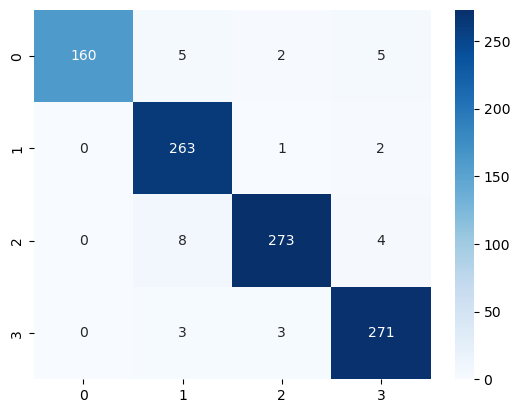

In [31]:
cm = confusion_matrix(df_test['sentiment'], y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')